# Image segmentaion with masked facies

Squish rectangular images to square

Using mask images processed in 01_02_mask_processing

512x512 size - images cropped - generated in 01_03_image_mask_cropping
reduced to 256x256 in transforms

Using 2200x512 sized imaged from mpl that have been cropped

diff wrt 02_10_2_256_resnet34_masked_tab20_crop_val_set_0.ipynb is that were we use pre-resized images (in other nb resize on the fly)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from numbers import Integral
from random import uniform
from PIL import Image as pil_image
import fastai
from fastai.vision import *
from fastai.vision import Image
from fastai.vision.transform import _minus_epsilon
from fastai.vision.data import SegmentationProcessor
from fastai.vision.interpret import SegmentationInterpretation
from mask_functions import *
from collections import defaultdict
import cv2
from IPython.display import display 
import datetime
import uuid
from scipy.stats import mode

In [3]:
fastai.__version__

'1.0.60.dev0'

In [4]:
torch.cuda.set_device(0)

In [5]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')    

UID: e4be1027, DATE: 20191222


In [59]:
UID='94b27c81'
DATE='20191222'
NB='02_10_2'
DESCR='rn34'

In [15]:
SUBSET_DATA=False
SUBSET_LEN=171
VALIDATION_FILE='val_20pct_1.csv'

#training image size
TGT_HEIGHT_SMALL = 128
TGT_HEIGHT_MEDIUM = 256
TGT_HEIGHT_FULL = 512

In [16]:
data_dir = Path('../data')
train_images = data_dir/'train_images'
train_path = train_images/'cropped_512/train'
train_mask = train_path/'masks_256'
train_img = train_path/'images_256'

test_img = train_images/'test'

In [17]:
filename = data_dir/'CAX_LogFacies_Train_File.csv'

In [18]:
file_test = data_dir/'CAX_LogFacies_Test_File.csv'

#### all data

In [19]:
training_data = pd.read_csv(filename)
training_data.head()
training_data['well_file']='well_'+training_data['well_id'].astype(str)+'.png'
wells=training_data['well_file'].unique()
all_wells_df=pd.DataFrame(wells)
all_wells_df.head()

,0
0,well_0.png
1,well_1.png
2,well_2.png
3,well_3.png
4,well_4.png


In [20]:
test_df = pd.read_csv(file_test)
test_df.head()

,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.950000
1,CAX_1,1,5000,120.896397
2,CAX_2,2,5000,115.342793
3,CAX_3,3,5000,118.859190
4,CAX_4,4,5000,127.735587


### Data

In [21]:
train_img

PosixPath('../data/train_images/cropped_512/train/images_256')

In [22]:
train_img_names = get_image_files(train_img)
len(train_img_names)

32000

In [23]:
train_img_names[:3]

[PosixPath('../data/train_images/cropped_512/train/images_256/well_3666_crop_3.png'),
 PosixPath('../data/train_images/cropped_512/train/images_256/well_3886_crop_6.png'),
 PosixPath('../data/train_images/cropped_512/train/images_256/well_2037_crop_6.png')]

#### Cropped images

In [24]:
for im in train_img_names:
    assert 'crop' in str(im)

In [25]:
train_mask_names = get_image_files(train_mask)
train_mask_names[:3]

[PosixPath('../data/train_images/cropped_512/train/masks_256/well_3666_crop_3.png'),
 PosixPath('../data/train_images/cropped_512/train/masks_256/well_3886_crop_6.png'),
 PosixPath('../data/train_images/cropped_512/train/masks_256/well_2037_crop_6.png')]

In [26]:
for im in train_mask_names:
    assert 'crop' in str(im)

### Data QC

In [27]:
inames=[]
mnames=[]
for im in train_img_names:
    inames.append(im.name)
for im in train_mask_names:
    mnames.append(im.name)

In [28]:
train_img_names[0]

PosixPath('../data/train_images/cropped_512/train/images_256/well_3666_crop_3.png')

In [29]:
missing_i_m=set(inames) - set(mnames)

In [30]:
missing_m_i= set(mnames)-set(inames) 

In [31]:
#assert len(missing_i_m)==len(missing_m_i)==0

In [32]:
len(inames)

32000

In [33]:
len(mnames)

32000

In [34]:
inames.sort()
mnames.sort()

In [35]:
len(inames)

32000

In [36]:
for im,mm in zip(inames, mnames):
    assert im==mm
    img=train_img/f'{im}'
    mmg=train_mask/f'{mm}'
    img_ =pil_image.open(img)
    mmg_ =pil_image.open(mmg)
    if img_.size != mmg_.size:
        print(f'img_.size: {img_.size} != mmg_.size: {mmg_.size}')

In [37]:
train_img_names[100]

PosixPath('../data/train_images/cropped_512/train/images_256/well_1193_crop_3.png')

../data/train_images/cropped_512/train/images_256/well_1193_crop_3.png


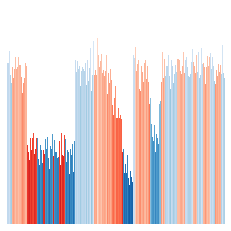

In [38]:
img_f = train_img_names[100]
print(img_f)
img_gr = open_image(img_f)
img_gr.show(figsize=(18,4))

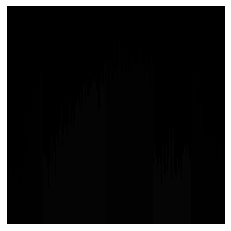

In [39]:
mask_f = train_mask_names[0]
mask_gr = open_image(mask_f)
mask_gr.show(figsize=(18,4))

### Link Masks with Images

In [40]:
get_y_fn = lambda x: train_mask/f'{x.stem}{x.suffix}' # converts from image to mask file name

In [41]:
get_y_fn(img_f)

PosixPath('../data/train_images/cropped_512/train/masks_256/well_1193_crop_3.png')

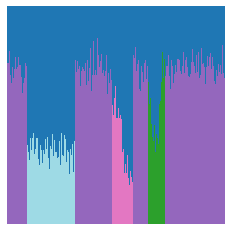

In [42]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(18,4), alpha=1)

In [43]:
u_values=[]
def get_all_uniques(images, subset=None):
    for i, im in enumerate(images):
        if subset and (i > subset):
            return u_values
        mask = np.asarray(pil_image.open(im))
        u_values.extend(np.unique(mask.tolist()))
    return u_values

In [44]:
#u_values=list(set(get_all_uniques(train_mask_names, 100)))
#u_values.sort()
#print(u_values)

Note that not all colours are mapped by fastai - we need to do this manually

### Log Facies

<pre>
            ▪ 0 (None), 
            ▪ 1 (Symmetrical), Hour glass (Prograding and retrograding)
            ▪ 2 (Cylindrical) Blocky sst (Aggrading)
            ▪ 3 (Funnel) Coarsening up (Prograding)
            ▪ 4 (Bell) Fining up (Retrograding)
</pre>



In [45]:
#codes = array(['Background', 'None', 'Symmetrical', 'Cylindrical', 'Funnel', 'Bell'])
codes = array(['Background', 'Funnel', 'None', 'Cylindrical', 'Symmetrical', 'Bell'])

In [46]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([256, 256]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2]]]))

In [47]:
gr_size = np.array(img_gr.shape[1:])
gr_size,img_gr.data

(array([256, 256]),
 tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.7608, 0.7608, 0.8078,  ..., 0.8275, 0.7020, 0.6784],
          [0.7608, 0.7608, 0.8078,  ..., 0.8275, 0.7020, 0.6784],
          [0.7608, 0.7608, 0.8078,  ..., 0.8275, 0.7020, 0.6784]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.8510, 0.8510, 0.8784,  ..., 0.8941, 0.8275, 0.8157],
          [0.8510, 0.8510, 0.8784,  ..., 0.8941, 0.8275, 0.8157],
          [0.8510, 0.8510, 0.8784,  ..., 0.8941, 0.8275, 0.8157]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1

## Datasets

First try using small (re)sized images

In [48]:
bs = 32

size=(TGT_HEIGHT_MEDIUM, TGT_HEIGHT_MEDIUM)

In [49]:
tfms=get_transforms(do_flip=False, flip_vert=False, max_rotate=0., max_zoom=1.1, max_lighting=0.0, \
                    max_warp=0., p_affine=0., p_lighting=0.0)

In [50]:
src = (SegmentationItemList.from_folder(path=train_img)
    .split_by_fname_file(f'../{VALIDATION_FILE}', path=train_img)
    .label_from_func(get_y_fn, classes=codes))

In [51]:
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [52]:
len(src.train.x)

25600

In [45]:
#src_test = (SegmentationItemList.from_folder(path=train_img)
#    .label_empty()
#    .split_none()
#    .add_test_folder(test_folder='../../test', tfms=None, tfm_y=False))

In [46]:
#data_test = (src_test.transform(size=size, tfms=None, tfm_y=False)
#        .databunch(bs=bs)
#        .normalize(imagenet_stats))

In [47]:
data.train_ds.x[0].shape

torch.Size([3, 256, 256])

In [48]:
#data_test.valid_ds.x[0].shape

In [49]:
data.train_ds.y[0].shape

torch.Size([1, 256, 256])

In [50]:
uy=[]
def get_unique_y_vals(data_list):
    for yt in data_list:
        y=yt.data.numpy()
        uy.extend(np.unique(y.tolist()))
    return uy

In [51]:
#u_values=list(set(get_unique_y_vals(data.train_ds.y)))
#u_values.sort()
#print(u_values)

In [52]:
#y=data.train_ds.y[0].data.numpy()

In [53]:
#np.unique(y)

In [54]:
data.label_list

LabelLists;

Train: LabelList (25600 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/train_images/cropped_512/train/images_256;

Valid: LabelList (6400 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/train_images/cropped_512/train/images_256;

Test: None

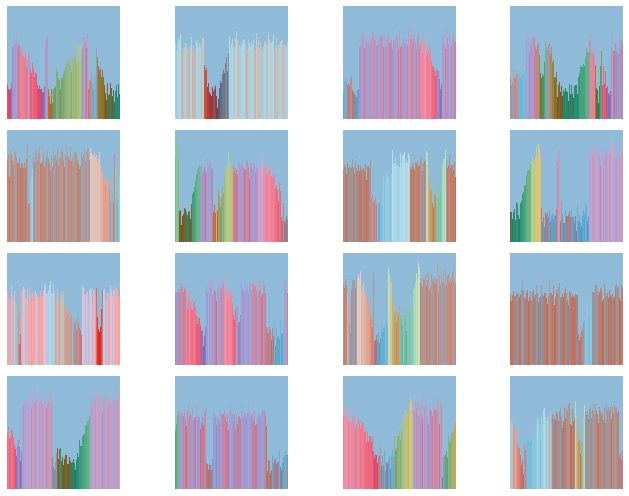

In [55]:
data.show_batch(4, figsize=(10,7))

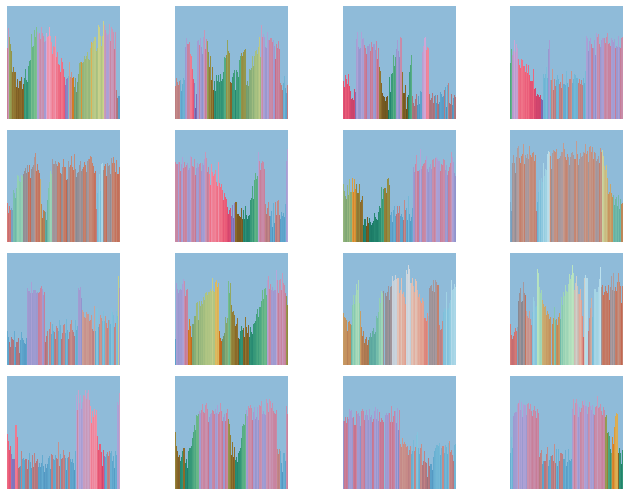

In [56]:
data.show_batch(4, figsize=(10,7), ds_type=DatasetType.Valid)

### Model

Eval criterion:
    
Classification Accuracy (percentage of correctly predicted rows)

In [57]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

def iou(input:Tensor, targs:Tensor) -> Rank0Tensor:
    "IoU coefficient metric for binary target."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    return intersect / (union-intersect+1.0)

Create an accuaracy metric that ignores the region above (when log is displayed horizontally) the GR log values

In [53]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']
print(void_code)

def acc_bgvoid(input, target):
    #print(f'in: {input.shape}, tgt: {target.shape}')
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

0


In [54]:
data

ImageDataBunch;

Train: LabelList (25600 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/train_images/cropped_512/train/images_256;

Valid: LabelList (6400 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/train_images/cropped_512/train/images_256;

Test: None

In [55]:
wd=1e-2

In [56]:
# Create U-Net with a pretrained resnet34 as encoder
learn = unet_learner(data, models.resnet34, metrics=acc_bgvoid, wd=wd).to_fp16()

In [62]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

In [63]:
learn.callback_fns

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False)]

In [64]:
#learn.loss_func=dice
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [65]:
#learn.pred_batch()

In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


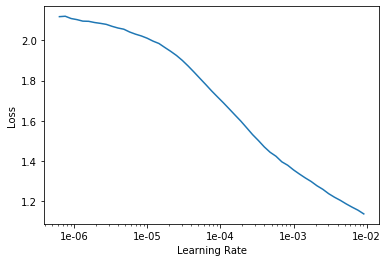

In [67]:
learn.recorder.plot()

In [68]:
lr=5e-4

In [69]:
learn.fit(3, lr)

epoch,train_loss,valid_loss,acc_bgvoid,time
0,0.114321,0.109440,0.932649,07:13
1,0.093532,0.096891,0.941628,06:53
2,0.077531,0.082268,0.950371,06:37


In [70]:
learn.save(f'{NB}-{UID}_{DESCR}_{TGT_HEIGHT_SMALL}-s1-r0-{DATE}')

In [71]:
learn.fit(3, lr)

epoch,train_loss,valid_loss,acc_bgvoid,time
0,0.067847,0.079274,0.952065,06:29
1,0.062048,0.085837,0.950838,06:18
2,0.051364,0.081589,0.954443,06:40


In [72]:
learn.load(f'{NB}-{UID}_{DESCR}_{TGT_HEIGHT_SMALL}-s1-r0-{DATE}')

Learner(data=ImageDataBunch;

Train: LabelList (25600 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/train_images/cropped_512/train/images_256;

Valid: LabelList (6400 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/train_images/cropped_512/train/images_256;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [73]:
learn.fit(1, lr)

epoch,train_loss,valid_loss,acc_bgvoid,time
0,0.068907,0.086770,0.947440,06:52


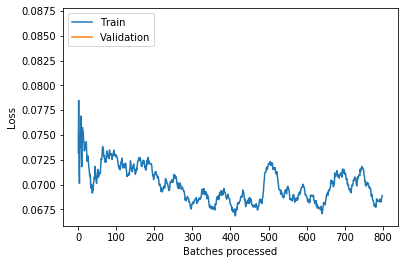

In [74]:
learn.recorder.plot_losses()

### Re-train

In [75]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


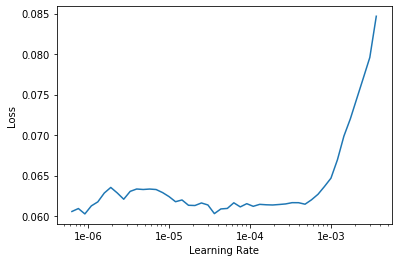

In [76]:
learn.lr_find()
learn.recorder.plot()

In [77]:
learn.fit(2, 1e-5)

epoch,train_loss,valid_loss,acc_bgvoid,time
0,0.048749,0.071481,0.957583,06:50
1,0.044203,0.072039,0.958363,06:36


In [78]:
learn.save(f'{NB}-{UID}_{DESCR}_{TGT_HEIGHT_MEDIUM}-s2-r0-{DATE}')

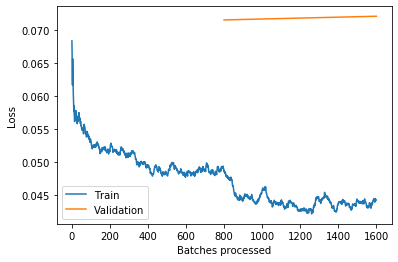

In [79]:
learn.recorder.plot_losses()

In [80]:
print(f'{NB}-{UID}_{DESCR}_{TGT_HEIGHT_MEDIUM}-s2-r0-{DATE}')

02_10_2-94b27c81_rn34_256-s2-r0-20191222


In [60]:
learn.load(f'{NB}-{UID}_{DESCR}_{TGT_HEIGHT_MEDIUM}-s2-r0-{DATE}')

Learner(data=ImageDataBunch;

Train: LabelList (25600 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/train_images/cropped_512/train/images_256;

Valid: LabelList (6400 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/train_images/cropped_512/train/images_256;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [61]:
learn.path

PosixPath('../data/train_images/cropped_512/train/images_256')

In [62]:
learn=learn.to_fp32()
learn.export(f'{NB}-{UID}_{DESCR}_{TGT_HEIGHT_MEDIUM}-s2-r0-{DATE}.pkl')

### Loss QC

In [81]:
learn.load(f'{NB}-{UID}_{DESCR}_{TGT_HEIGHT_MEDIUM}-s2-r0-{DATE}')

Learner(data=ImageDataBunch;

Train: LabelList (25600 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/train_images/cropped_512/train/images_256;

Valid: LabelList (6400 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/train_images/cropped_512/train/images_256;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [63]:
learn.data.classes

array(['Background', 'Funnel', 'None', 'Cylindrical', 'Symmetrical', 'Bell'], dtype='<U11')

In [64]:
interp=SegmentationInterpretation.from_learner(learn)

In [65]:
top_losses, top_idxs=interp.top_losses((TGT_HEIGHT_MEDIUM,TGT_HEIGHT_MEDIUM))

In [66]:
top_losses, top_idxs

(tensor([1.4559e+00, 1.0881e+00, 1.0610e+00,  ..., 9.5600e-05, 8.3255e-05,
         3.9895e-05]), tensor([4846, 1618, 4757,  ..., 2650,  397, 4068]))

In [67]:
top_losses.shape

torch.Size([6400])

In [68]:
top_idxs.shape

torch.Size([6400])

In [69]:
top_idxs[:20]

tensor([4846, 1618, 4757, 3387, 3500, 3993, 4781, 3355, 5045, 2404, 6277, 2820,
        5715, 1199,  597, 4256, 4864, 2453, 5273, 5942])

In [70]:
tnp=top_idxs.numpy()
idxs=tnp[tnp<800]

tensor(0.1740)


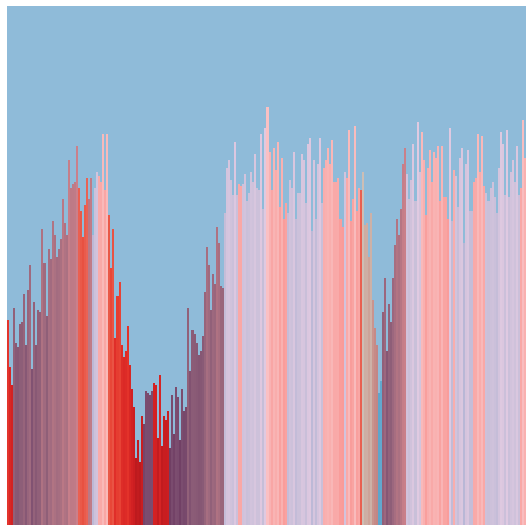

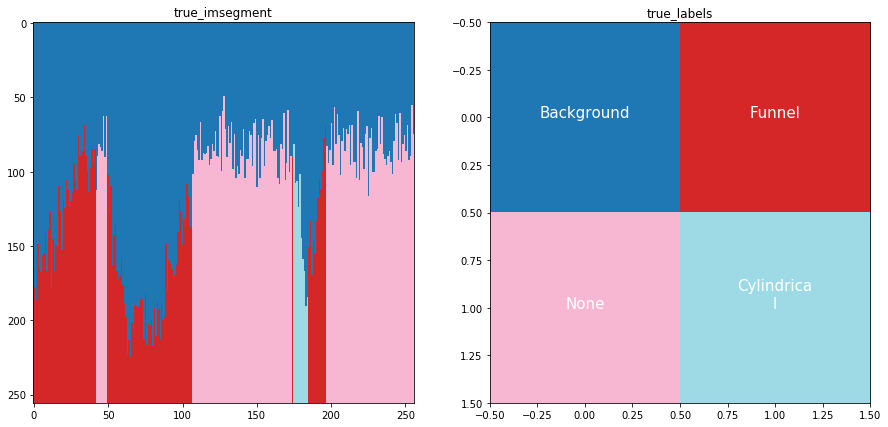

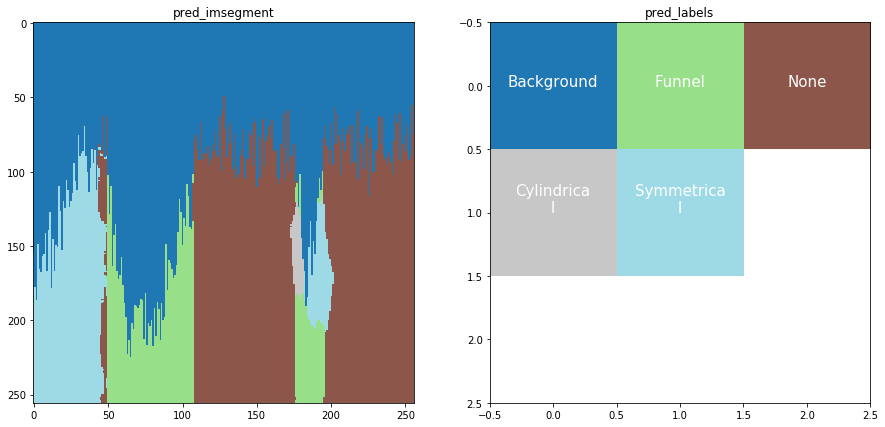

In [71]:
# show top loss
print(top_losses[idxs[0]])
interp.show_xyz(idxs[0], codes, sz=15)

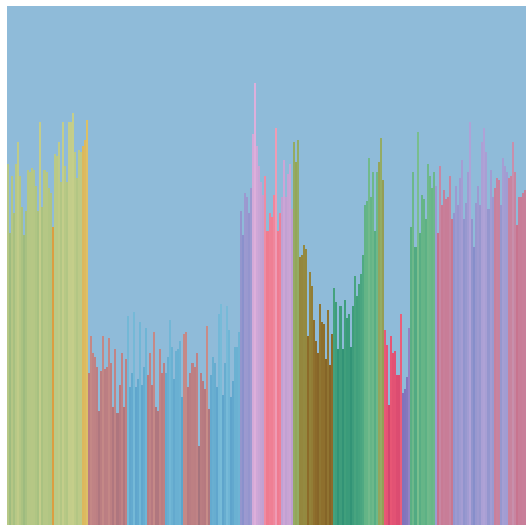

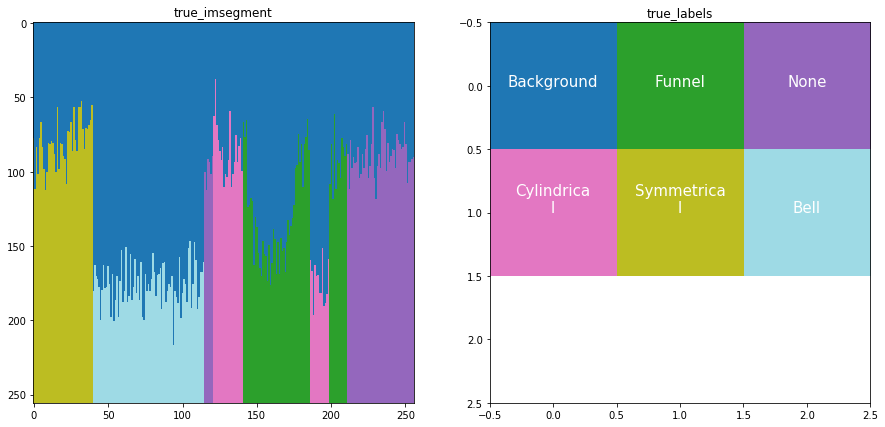

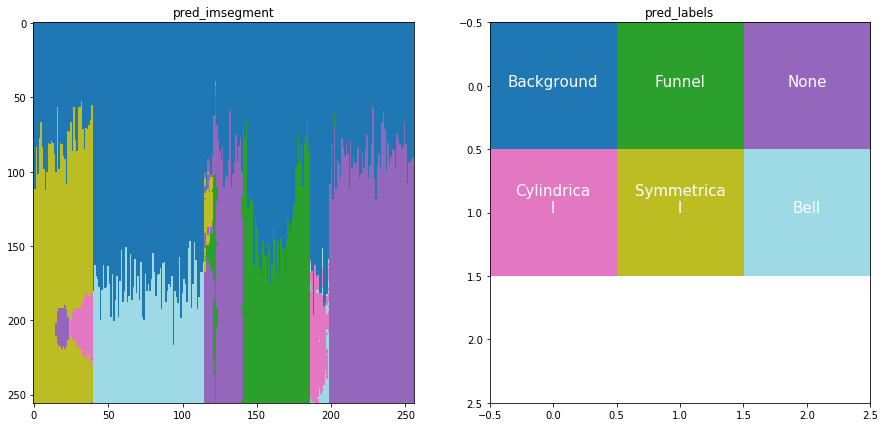

In [72]:
interp.show_xyz(idxs[3], codes, sz=15)

### Loss Distribution

(array([4.284e+03, 1.279e+03, 4.700e+02, 1.800e+02, 9.100e+01, 4.700e+01, 2.100e+01, 1.200e+01, 4.000e+00, 5.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([3.989464e-05, 7.283267e-02, 1.456254e-01, 2.184182e-01, 2.912110e-01, 3.640038e-01, 4.367965e-01, 5.095893e-01,
        5.823821e-01, 6.551749e-01, 7.279677e-01, 8.007604e-01, 8.735532e-01, 9.463460e-01, 1.019139e+00, 1.091932e+00,
        1.164724e+00, 1.237517e+00, 1.310310e+00, 1.383103e+00, 1.455895e+00], dtype=float32),
 <a list of 20 Patch objects>)

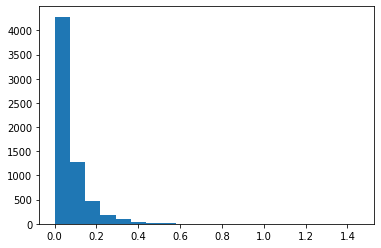

In [73]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

In [74]:
# top loss idxs of images
top_idxs[:5]

tensor([4846, 1618, 4757, 3387, 3500])

In [75]:
mean_cm, single_img_cm = interp._generate_confusion()

In [76]:
mean_cm.shape, single_img_cm.shape

((6, 6), (6400, 6, 6))

label,score
Background,0.99999
None,0.979677
Bell,0.895314
Cylindrical,0.841695
Funnel,0.837908
Symmetrical,0.820141


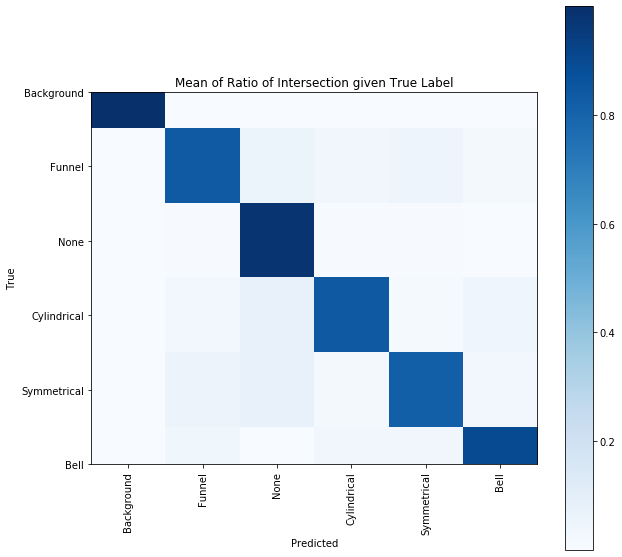

In [77]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

label,score
Background,0.999957
None,0.996009
Symmetrical,0.947719
Bell,0.133829
Funnel,NaN
Cylindrical,NaN


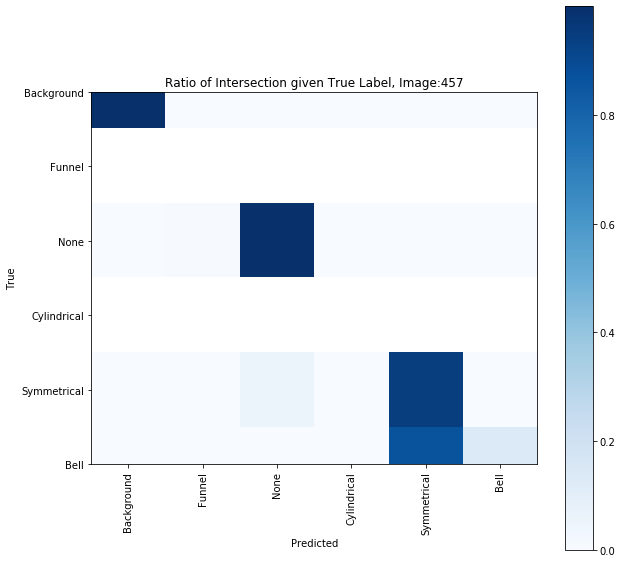

In [78]:
# single image class performance
i = 457
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

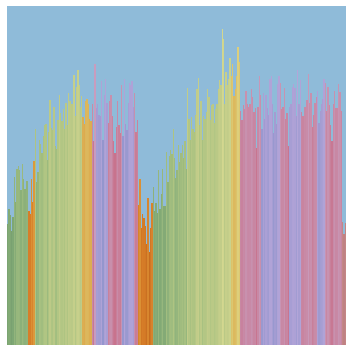

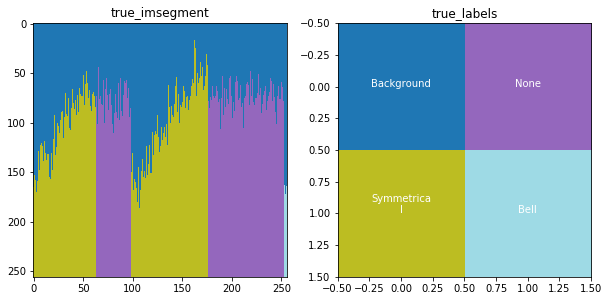

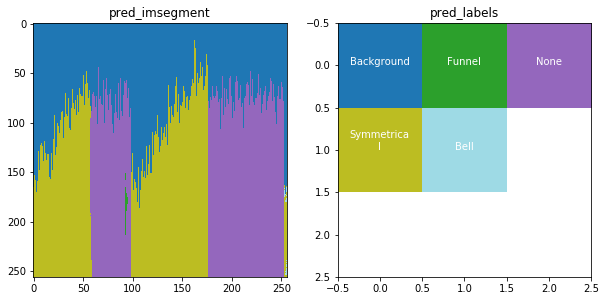

In [79]:
# show xyz
interp.show_xyz(i)